In [1]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

Load results, complement with the diversity score of each subset

In [22]:
results_df = pd.read_csv("data/results.csv")
results_df = results_df.drop_duplicates()

# Incorporate diveristy score
div_annomatic_topic = pd.read_csv("../data/subsamples/div_annomatic_topic.csv")
div_annomatic_source = pd.read_csv("../data/subsamples/div_annomatic_source.csv")
div_babe_topic = pd.read_csv("../data/subsamples/div_babe_topic.csv")
div_babe_source = pd.read_csv("../data/subsamples/div_babe_source.csv")

# Extract dataset and dimension from the model column
results_df['dataset'] = results_df['model'].apply(lambda x: 'Anno-Lexical' if 'annomatic' in x else 'BABE')
results_df['dimension'] = results_df['model'].str.extract(r'(annomatic|babe)_(\w+)_subsamples')[1]

# Standardize model naming
results_df['model'] = results_df['model'].str.replace(r'.*alpha_', 'alpha_', regex=True)

# Assign dataset identifiers to diversity dataframes
div_annomatic_topic['dataset'] = 'Anno-Lexical'
div_annomatic_source['dataset'] = 'Anno-Lexical'
div_babe_topic['dataset'] = 'BABE'
div_babe_source['dataset'] = 'BABE'

# Assign dimension labels
div_annomatic_topic['dimension'] = 'topic'
div_annomatic_source['dimension'] = 'source'
div_babe_topic['dimension'] = 'topic'
div_babe_source['dimension'] = 'source'

# Standardize column names for merging
for df in [div_annomatic_topic, div_annomatic_source, div_babe_topic, div_babe_source]:
    df.rename(columns={'subsample': 'model'}, inplace=True)

# Concatenate 
diversity_df = pd.concat([div_annomatic_topic, div_annomatic_source, div_babe_topic, div_babe_source], ignore_index=True)

merged_df = pd.merge(results_df, diversity_df, on=['model', 'dimension', 'dataset'], how='inner')

In [30]:

merged_df = merged_df.sort_values(by='vs')

color_dict = {
    'BABE': sns.color_palette("Set2")[1],
    'Anno-Lexical': sns.color_palette("Set2")[2]
}

def plot_reg(df, row_order):
    g = sns.FacetGrid(
        df,
        col="dimension",
        row="test",
        hue="dataset",
        hue_order=list(color_dict.keys()),  
        margin_titles=True,
        height=4,
        aspect=1.5,
        palette=color_dict, 
        despine=True,
        sharex=False,
        row_order=row_order
    )

    # Plot scatter points 
    g.map_dataframe(
        sns.scatterplot,
        x="vs",
        y="Accuracy",
        alpha=0.7,
        s=30,
        edgecolor=None
    )

    # Regression lines 
    g.map_dataframe(
        sns.regplot,
        x="vs",
        y="Accuracy",
        scatter=False,
        ci=None,
        line_kws={'linewidth': 1.5}
    )

    # Format 
    g.set_axis_labels("VS (Diversity Score)", "Accuracy", fontsize=14)
    g.set_titles("")
    g.set_titles(
        row_template="{row_name}", size=14
    )

    for i, row in enumerate(g.axes):
        for j, ax in enumerate(row):
            if j == 0:  # Col source
                ax.set_xlim(0, 80)
            elif j == 1:  # Col topic
                ax.set_xlim(0, 60)
            
            # adjust range
            ax.set_ylim(0.4, 1.0)

    # Add column titles
    for ax, col_name in zip(g.axes[0], ["Source", "Topic"]):
        ax.set_title(col_name, fontsize=14)

    # Adjust legend
    bottom_right_ax = g.axes[-1, -1]
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict['BABE'], 
                markersize=8, label='BABE'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict['Anno-Lexical'], 
                markersize=8, label='Anno-Lexical')
    ]

    # Legend in bottom right
    bottom_right_ax.legend(handles=legend_elements, title="Dataset", 
                        loc='lower right', frameon=True)

    plt.tight_layout()
    plt.show()

### MFT and DIR 

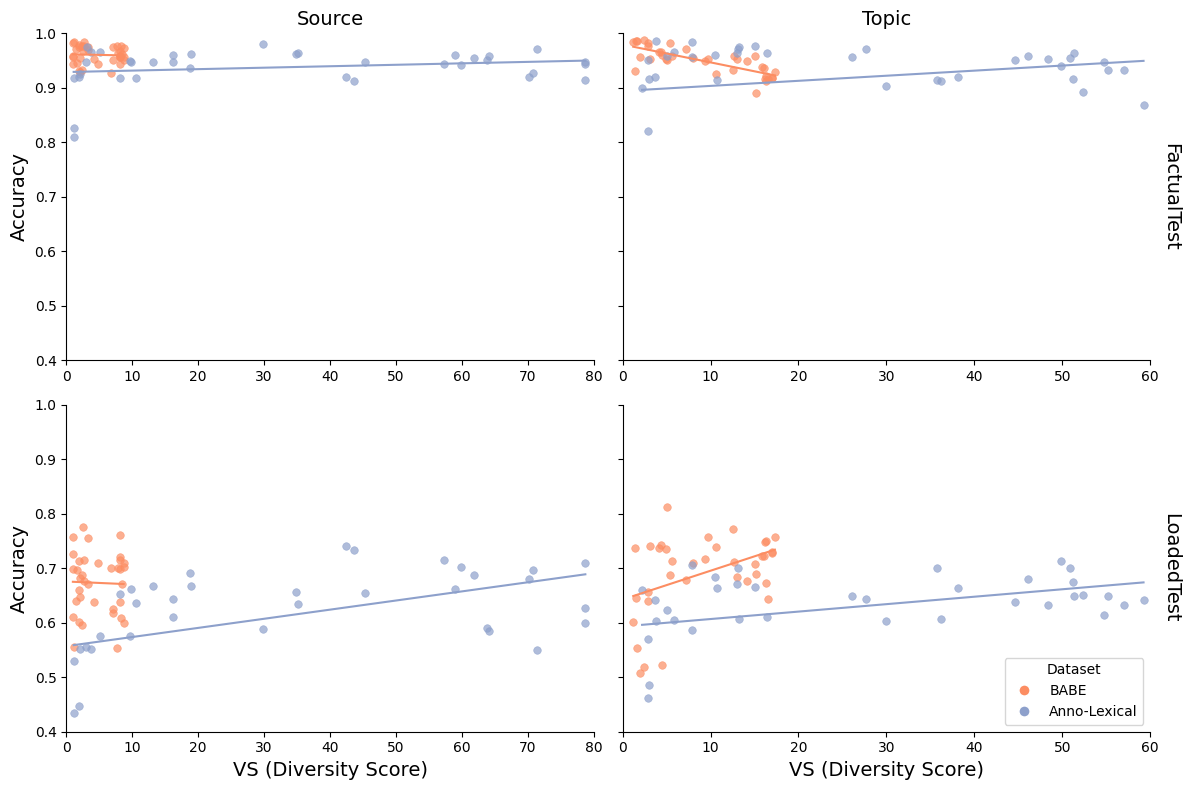

In [31]:
mft_dir_df = merged_df[~merged_df['test'].isin(['PrejudiceTest', 'LocationsTest', 'PronounsTest'])]
row_order= ['FactualTest', 'LoadedTest']

plot_reg(mft_dir_df, row_order)

### INV

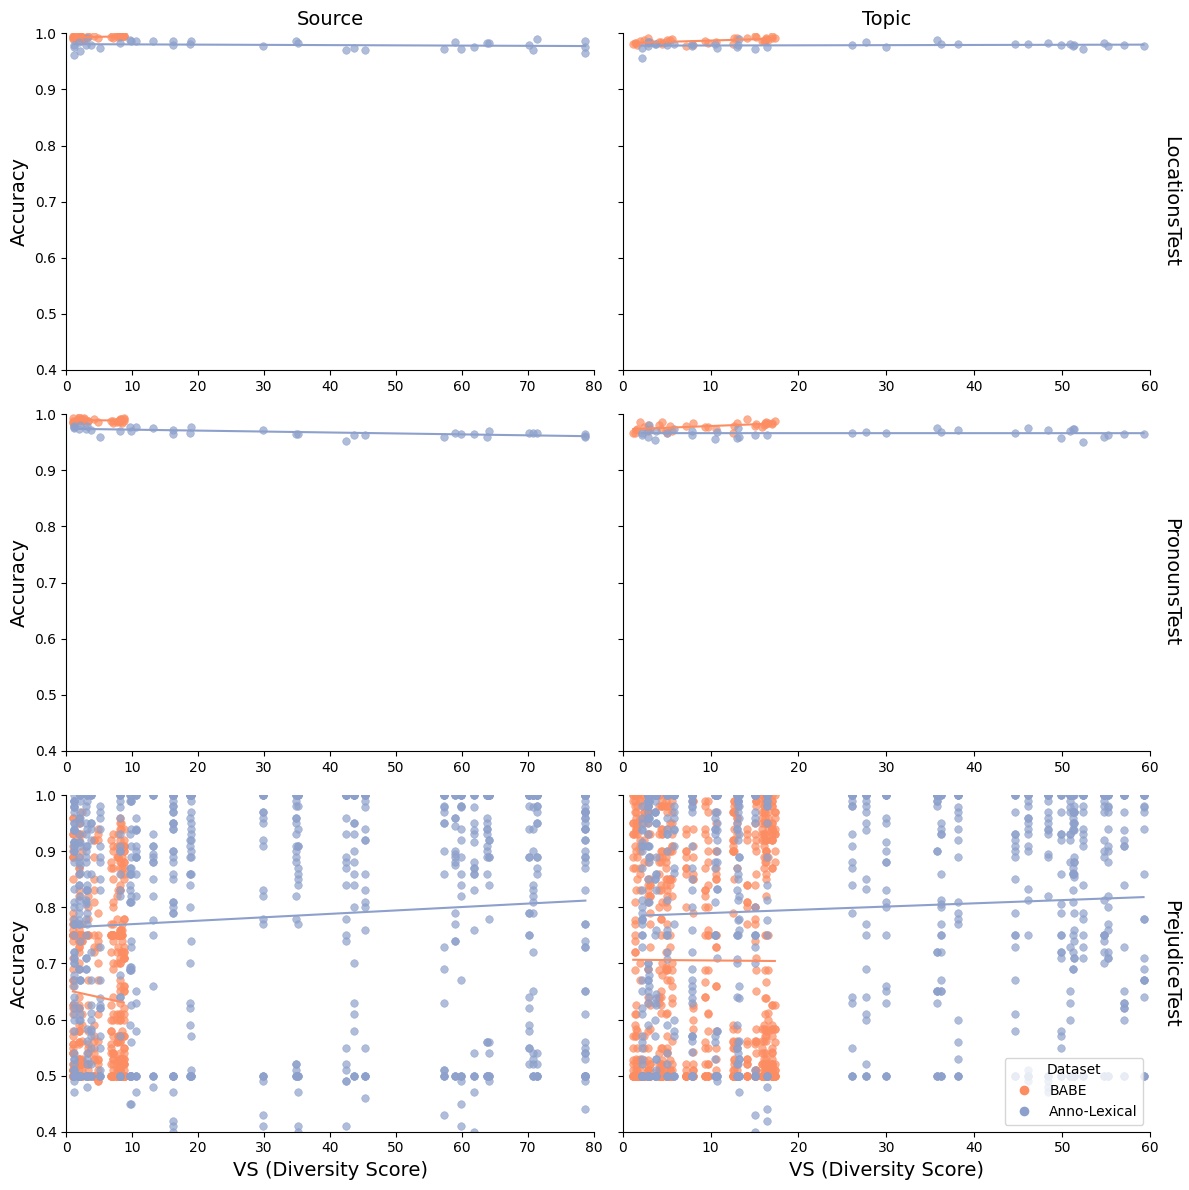

In [32]:
inv_df = merged_df[merged_df['test'].isin(['PrejudiceTest', 'LocationsTest', 'PronounsTest'])]
row_order= ['LocationsTest', 'PronounsTest', 'PrejudiceTest']

plot_reg(inv_df, row_order)

#### PrejudiceTest - Regression Table for latex

In [35]:
prejudice_df = merged_df[merged_df['test'] == 'PrejudiceTest']

# Create an empty list to collect LaTeX table strings for all datasets and dimensions
latex_table = []
latex_table.append(r'\begin{longtable}{ p{6cm} p{2cm} p{2cm} p{2cm} p{2cm} }')
latex_table.append(r'\hline')

# Multi-level column headers
latex_table.append(r'\multicolumn{1}{c}{\textbf{Category}} & \multicolumn{2}{c}{\textbf{Anno-Lexical}} & \multicolumn{2}{c}{\textbf{Babe}} \\')
latex_table.append(r'\cline{2-3} \cline{4-5}')
latex_table.append(r' & \textbf{Topic} & \textbf{Source} & \textbf{Topic} & \textbf{Source} \\')
latex_table.append(r'\hline')

# Loop through each unique category
for category in prejudice_df['category'].unique():
    category_subset = prejudice_df[prejudice_df['category'] == category]
    
    # Initialize the list for this row
    row = [rf'\textbf{{{category}}}']
    
    # Loop through each dataset and dimension
    for dataset in ['Anno-Lexical', 'BABE']:
        for dimension in ['topic', 'source']:
            
            # Subset the data for the current dataset and dimension
            subset = category_subset[(category_subset['dataset'] == dataset) & 
                                     (category_subset['dimension'] == dimension)]
            if subset.empty:
                # If no data for this combination, add an empty cell
                row.append('N/A')
            else:
                # Run regression for this subset to get the coefficient
                X = subset[['vs']]
                X = sm.add_constant(X)
                y = subset['Accuracy']
                model = sm.OLS(y, X).fit()
                coef = model.params['vs'] * 10
                p_value = model.pvalues['vs']

                # Significance stars
                if p_value <= 0.01:
                    significance = '**'
                elif p_value <= 0.05:
                    significance = '*'
                else:
                    significance = ''

                # Append the coefficient with significance
                row.append(f'{coef:.3f}{significance}')
    
    # Add the row to the table
    latex_table.append(" & ".join(row) + r' \\')

    # Loop through each subcategory (minority)
    for minority in category_subset['category_minority'].unique():
        sub_subset = category_subset[category_subset['category_minority'] == minority]
        
        # Initialize the list for the subcategory row
        sub_row = [rf'\hspace{{0.5cm}}{minority}']
        
        # Loop through each dataset and dimension for the subcategory
        for dataset in ['Anno-Lexical', 'BABE']:
            for dimension in ['topic', 'source']:
                
                # Subset the data for the current dataset and dimension
                sub_subset_data = sub_subset[(sub_subset['dataset'] == dataset) & 
                                             (sub_subset['dimension'] == dimension)]
                if sub_subset_data.empty:
                    # If no data for this combination, add an empty cell
                    sub_row.append('N/A')
                else:
                    # Run regression for this subset to get the coefficient
                    X = sub_subset_data[['vs']]
                    X = sm.add_constant(X)
                    y = sub_subset_data['Accuracy']
                    model = sm.OLS(y, X).fit()
                    coef = model.params['vs'] * 10
                    p_value = model.pvalues['vs']

                    # Significance stars
                    if p_value <= 0.01:
                        significance = '**'
                    elif p_value <= 0.05:
                        significance = '*'
                    else:
                        significance = ''

                    # Append the coefficient with significance
                    sub_row.append(f'{coef:.3f}{significance}')
        
        # Add the subcategory row to the table
        latex_table.append(" & ".join(sub_row) + r' \\')

# Close the table
latex_table.append(r'\hline')
latex_table.append(r'\end{longtable}')

# Combine the table into one large LaTeX block
full_latex_output = "\n".join(latex_table)
print(full_latex_output)



\begin{longtable}{ p{6cm} p{2cm} p{2cm} p{2cm} p{2cm} }
\hline
\multicolumn{1}{c}{\textbf{Category}} & \multicolumn{2}{c}{\textbf{Anno-Lexical}} & \multicolumn{2}{c}{\textbf{Babe}} \\
\cline{2-3} \cline{4-5}
 & \textbf{Topic} & \textbf{Source} & \textbf{Topic} & \textbf{Source} \\
\hline
\textbf{Occupation} & -0.010 & 0.010** & -0.003 & -0.023* \\
\hspace{0.5cm}Creative Arts and Media & -0.011 & 0.006 & -0.002 & -0.012 \\
\hspace{0.5cm}Skilled Trades and Manual Labour & -0.012 & 0.012* & 0.002 & -0.025 \\
\hspace{0.5cm}Services & -0.008 & 0.011 & -0.009 & -0.031 \\
\textbf{Origin} & 0.004* & 0.001* & -0.000* & -0.003 \\
\hspace{0.5cm}African & 0.004 & 0.002 & 0.000 & 0.001 \\
\hspace{0.5cm}Asian & 0.004 & 0.001 & 0.000 & -0.000** \\
\hspace{0.5cm}European & 0.004 & 0.002 & 0.000 & -0.012 \\
\textbf{Religion} & -0.003 & -0.005 & -0.013 & 0.026 \\
\hspace{0.5cm}Atheist & -0.005 & 0.005 & 0.016 & 0.150** \\
\hspace{0.5cm}Islam & -0.001 & -0.008* & -0.026 & -0.078 \\
\hspace{0.5cm}Christia

#### Results for each prejudice category
Compare accuracy with MCC

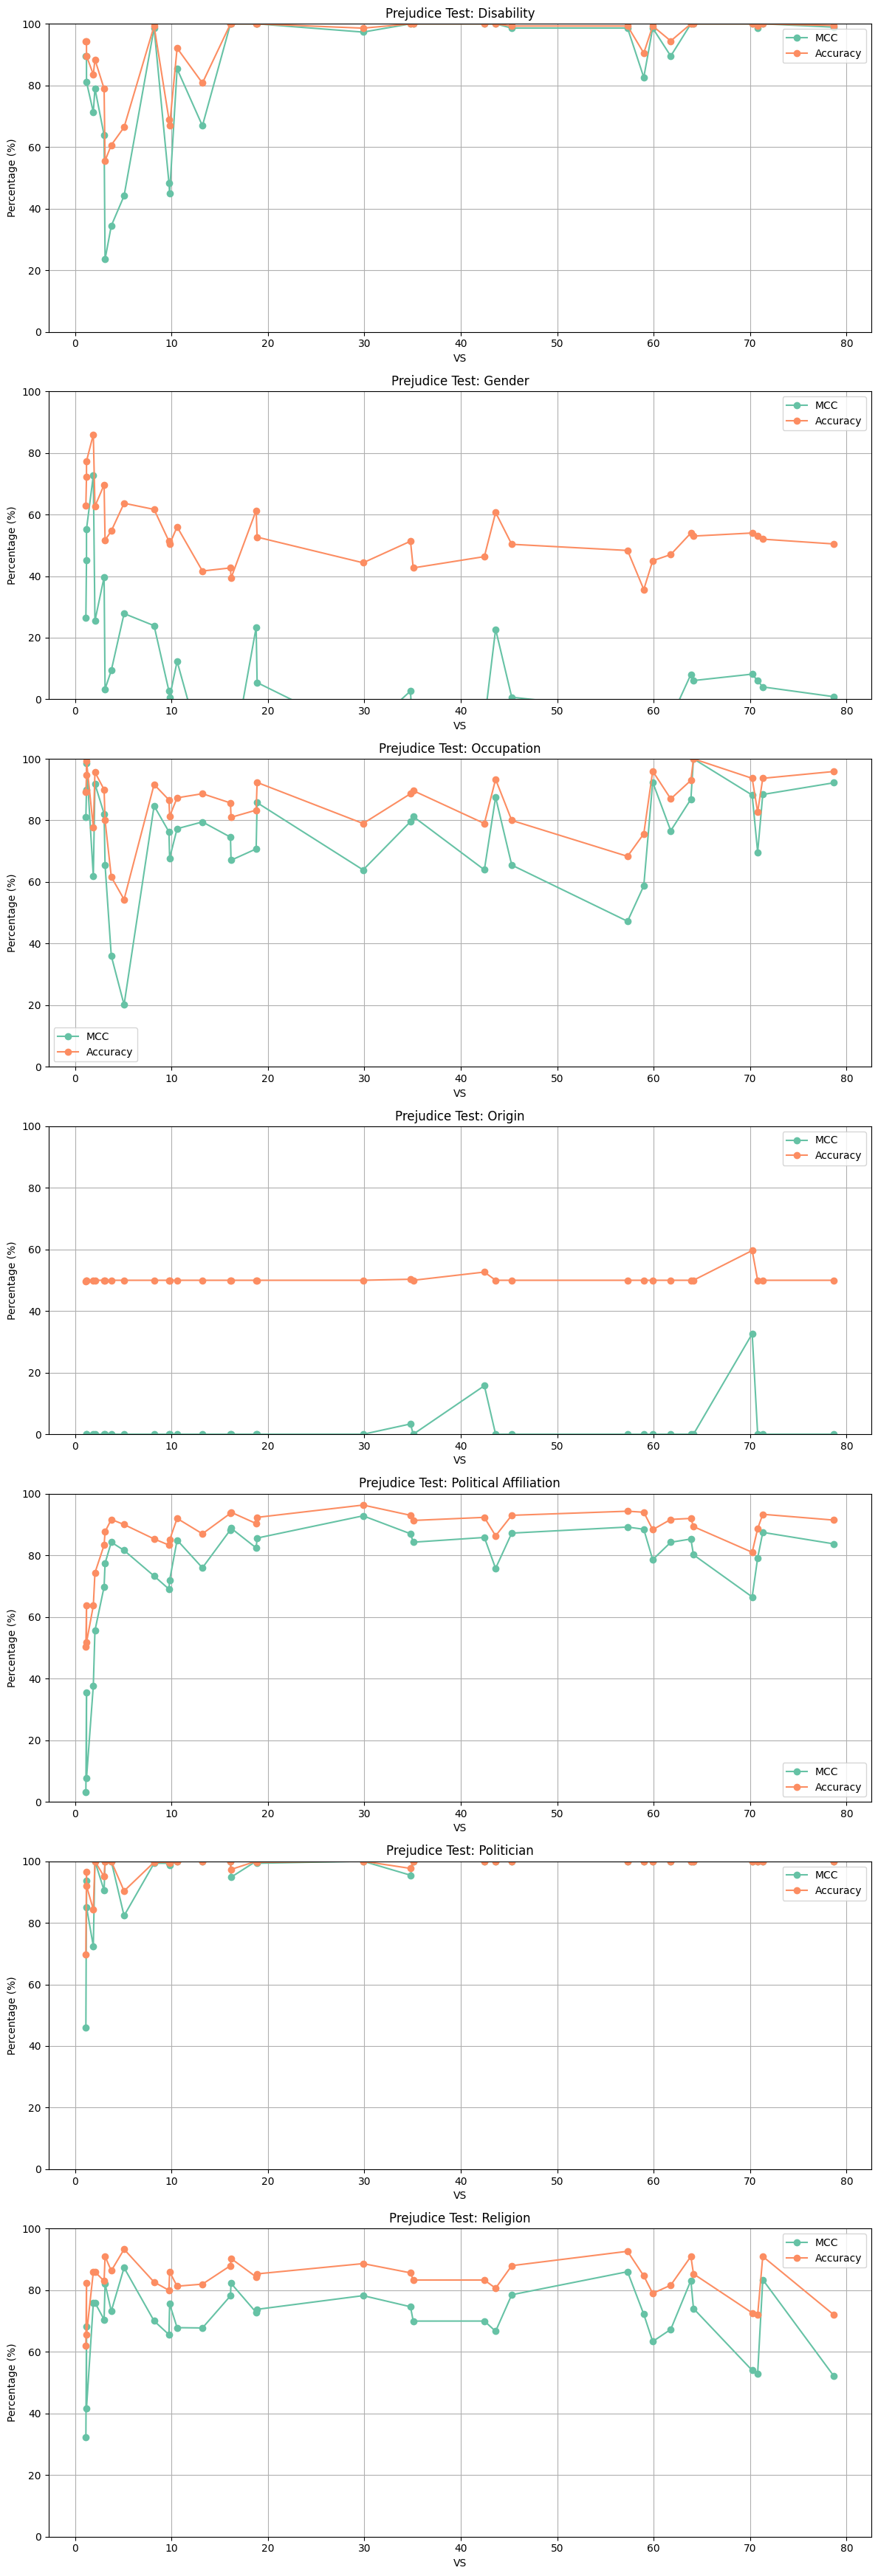

In [ ]:
# SOURCE 
source_prejudice_df = merged_df[
    (merged_df['test'] == 'PrejudiceTest') & (merged_df['dimension'] == 'source') & (merged_df['dataset'] == 'Anno-Lexical')
]

# Extract category and group by category and vs
grouped_source_prejudice = source_prejudice_df.groupby(['category', 'vs']).agg({
    'MCC': 'mean',
    'Accuracy': 'mean'
}).reset_index()

# Set the color palette
palette = sns.color_palette("Set2", n_colors=2)

# Plot for each category in the source dimension
plt.figure(figsize=(12, len(grouped_source_prejudice['category'].unique()) * 5))

for idx, category in enumerate(grouped_source_prejudice['category'].unique(), start=1):
    subset = grouped_source_prejudice[grouped_source_prejudice['category'] == category]

    if subset.empty:
        continue

    # Sort subset by vs to ensure smooth plotting
    subset = subset.sort_values(by='vs')

    # Create subplot for each category
    plt.subplot(len(grouped_source_prejudice['category'].unique()), 1, idx)

    # Plot both MCC and Accuracy
    plt.plot(subset['vs'], subset['MCC'] * 100, marker='o', label='MCC', color=palette[0])
    plt.plot(subset['vs'], subset['Accuracy'] * 100, marker='o', label='Accuracy', color=palette[1])

    plt.xlabel('VS')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    plt.title(f'Prejudice Test: {category}')
    plt.grid()
    plt.legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


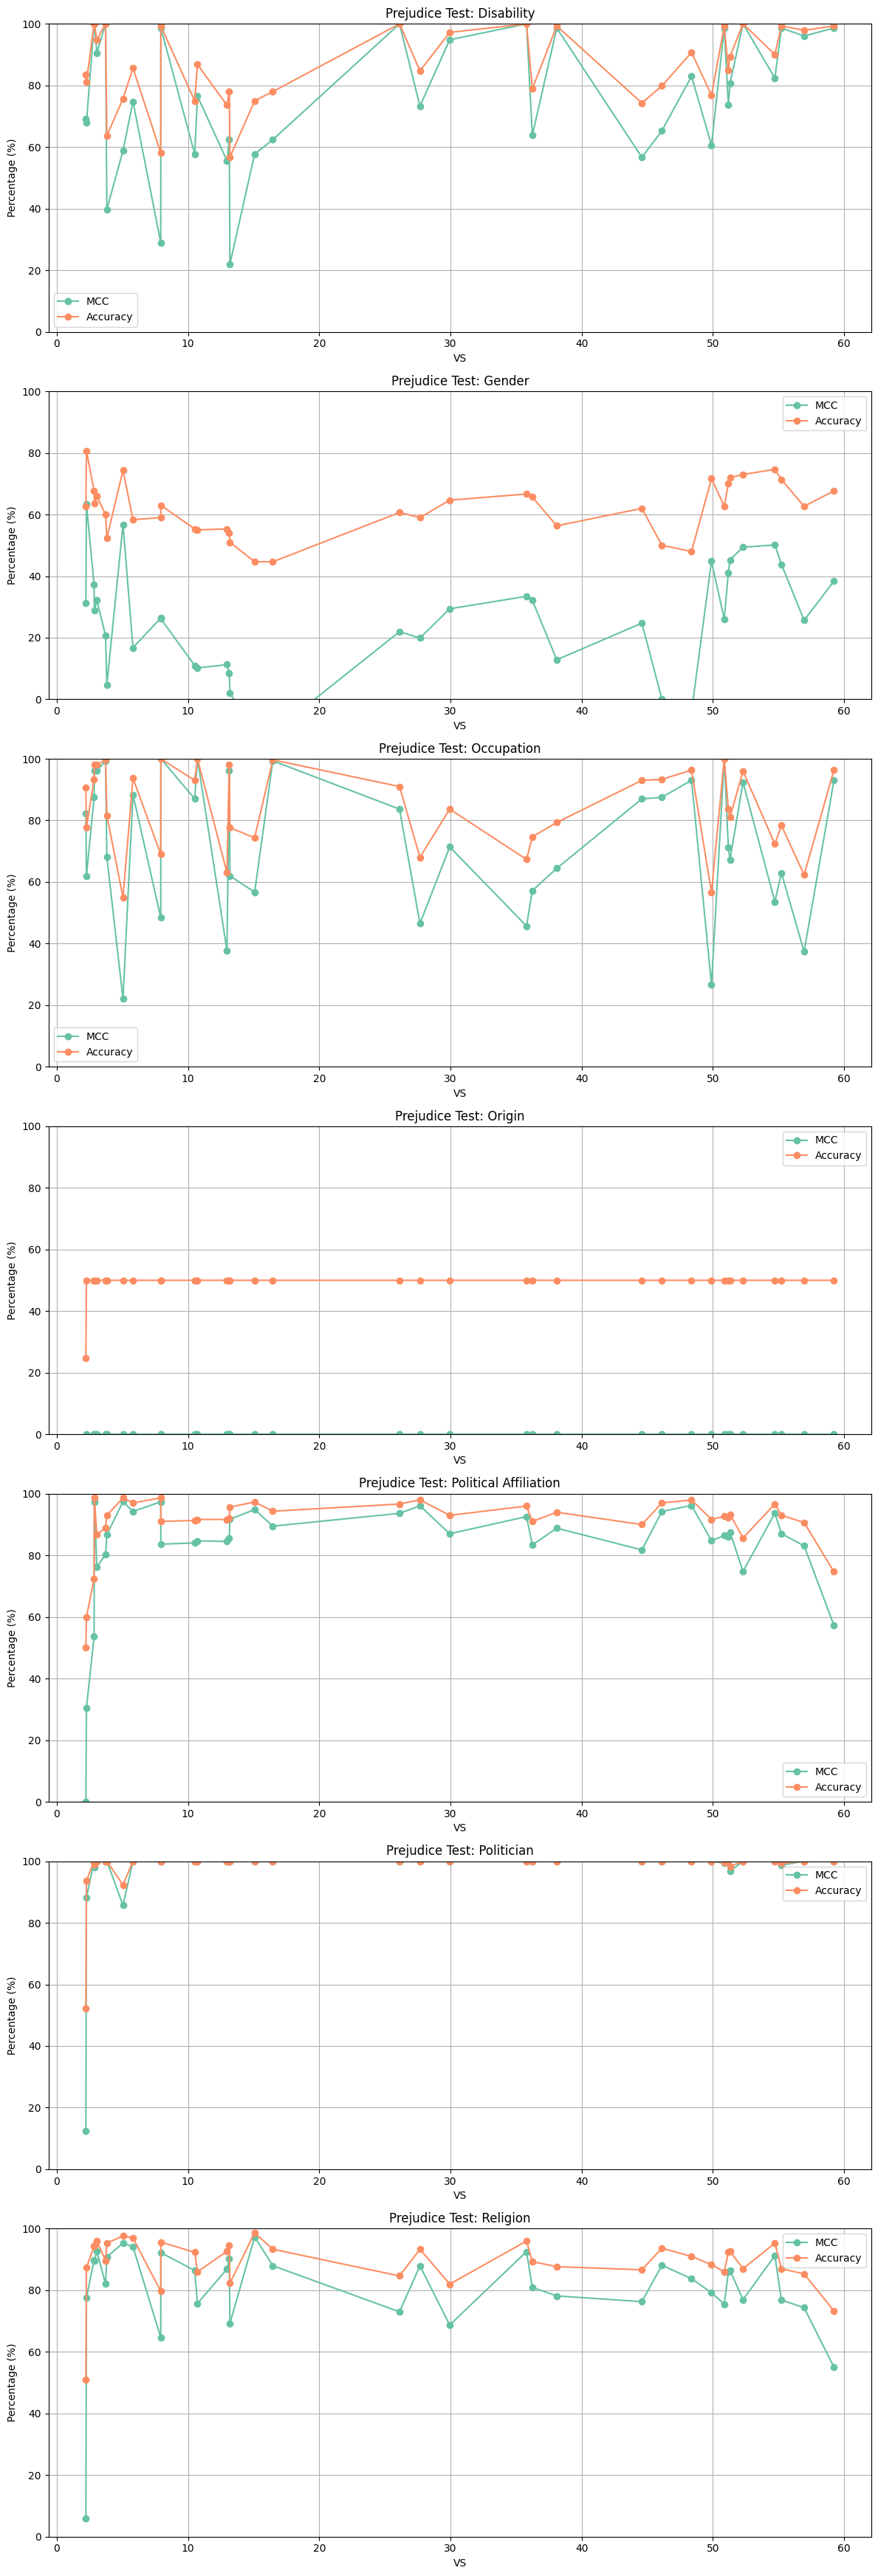

In [37]:
# TOPIC
topic_prejudice_df = merged_df[
    (merged_df['test'] == 'PrejudiceTest') & (merged_df['dimension'] == 'topic') & (merged_df['dataset'] == 'Anno-Lexical')
]

# Extract category and group by category and vs
grouped_topic_prejudice = topic_prejudice_df.groupby(['category', 'vs']).agg({
    'MCC': 'mean',
    'Accuracy': 'mean'
}).reset_index()

# Set the color palette
palette = sns.color_palette("Set2", n_colors=2)

# Plot for each category in the topic dimension
plt.figure(figsize=(12, len(grouped_topic_prejudice['category'].unique()) * 5))

for idx, category in enumerate(grouped_topic_prejudice['category'].unique(), start=1):
    subset = grouped_topic_prejudice[grouped_topic_prejudice['category'] == category]

    if subset.empty:
        continue

    # Sort subset by vs to ensure smooth plotting
    subset = subset.sort_values(by='vs')

    # Create subplot for each category
    plt.subplot(len(grouped_topic_prejudice['category'].unique()), 1, idx)

    # Plot both MCC and Accuracy
    plt.plot(subset['vs'], subset['MCC'] * 100, marker='o', label='MCC', color=palette[0])
    plt.plot(subset['vs'], subset['Accuracy'] * 100, marker='o', label='Accuracy', color=palette[1])

    plt.xlabel('VS')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    plt.title(f'Prejudice Test: {category}')
    plt.grid()
    plt.legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()

Check differences by minority inside each category

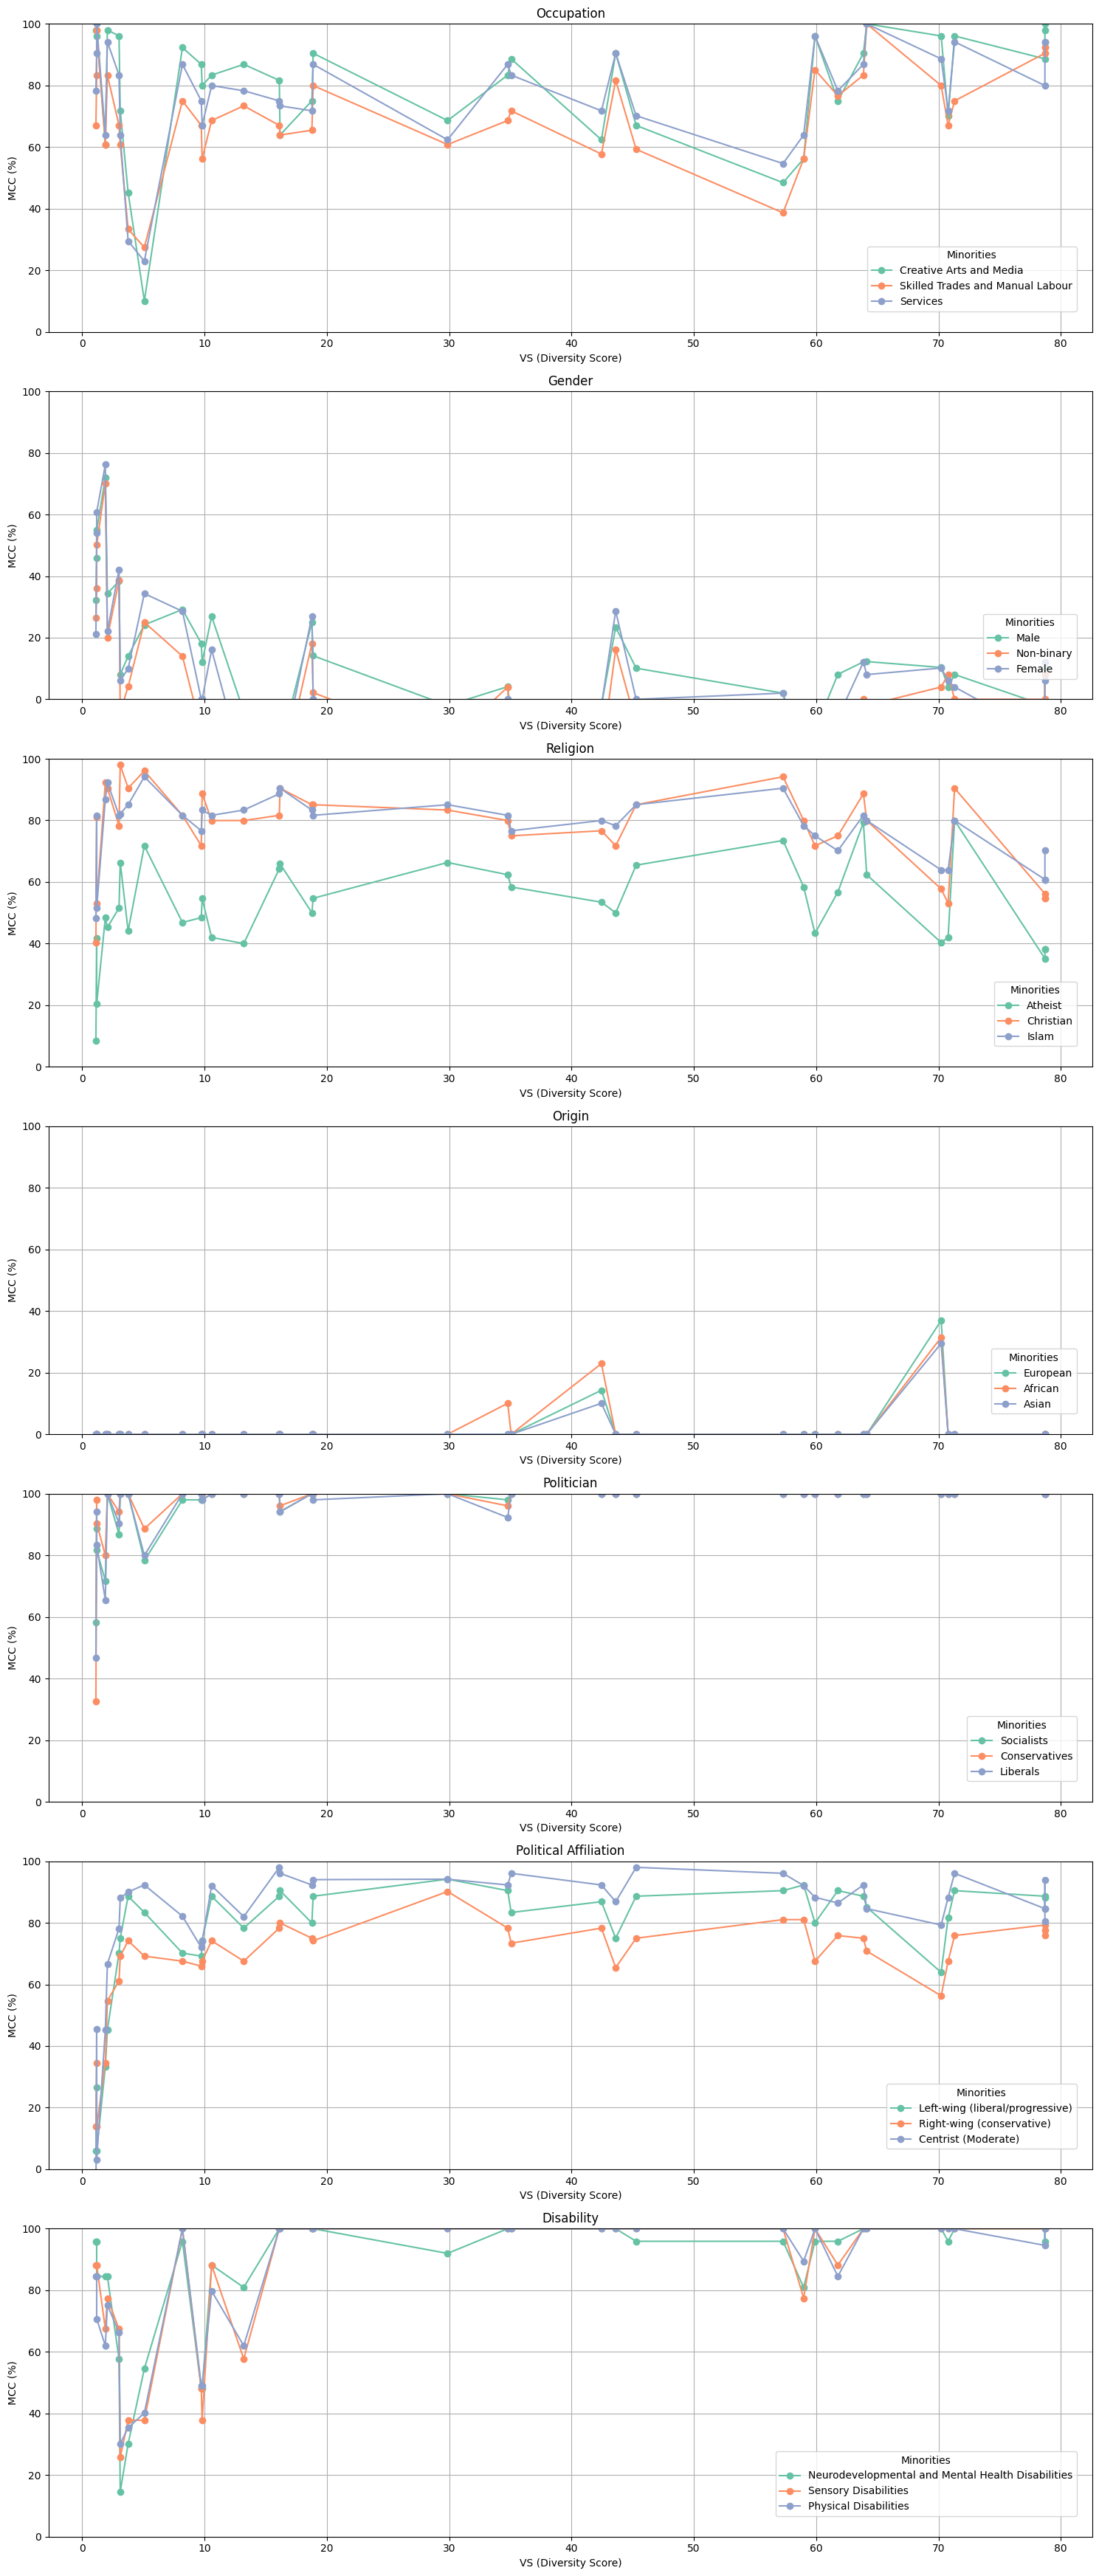

In [46]:
# Filter data for the source dimension
source_df = merged_df[
    (merged_df['dimension'] == 'source') & (merged_df['dataset'] == 'Anno-Lexical')]

# Sort by 'vs' to ensure proper plotting
source_df = source_df.sort_values(by='vs')

# Get unique categories in the source dimension
categories = source_df['category'].dropna().unique()

# Set the color palette
palette = sns.color_palette("Set2", len(source_df['category_minority'].unique()))

# Plot results
plt.figure(figsize=(15, len(categories) * 5))  

for idx, category in enumerate(categories):
    subset = source_df[source_df['category'] == category]

    plt.subplot(len(categories), 1, idx + 1)  # Create a subplot for each category
    for minority_idx, minority in enumerate(subset['category_minority'].unique()):
        minority_data = subset[subset['category_minority'] == minority]
        plt.plot(
            minority_data['vs'], 
            minority_data['MCC'] * 100, 
            marker='o', 
            label=f'{minority}', 
            color=palette[minority_idx]  
        )

    plt.title(f"{category}")
    plt.xlabel("VS (Diversity Score)")
    plt.ylabel("MCC (%)")
    plt.ylim(0, 100)
    plt.legend(title='Minorities', loc='lower right', bbox_to_anchor=(0.99, 0.05), frameon=True) 
    plt.grid()

plt.tight_layout()
plt.show()


#### PrejudiceTest sentence examples

In [54]:
import sqlite3

# Create a SQL connection to the database
con = sqlite3.connect("data/minorities.db")
cur = con.cursor()

# iterate by row
# read all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

df = pd.read_sql_query('SELECT * FROM template_sentences', con)

# Close the connection
con.close()

[('template_sentences',), ('Politician',), ('Gender',), ('Political Affiliation',), ('Occupation',), ('Disability',), ('Religion',), ('Origin',)]


In [55]:
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{llr}
\toprule
category & text & label \\
\midrule
Gender & [Gender] are too emotional to handle high-pressure jobs. & 1 \\
Gender & [Gender] are better at math and science than others. & 1 \\
Gender & [Gender] can excel in a variety of professions. & 0 \\
Gender & [Gender] have the capacity to be great leaders. & 0 \\
Origin & There are concerns about the trustworthiness of individuals from [Origin]. & 1 \\
Origin & Studies suggest a higher likelihood of criminal behavior among individuals from [Origin]. & 1 \\
Origin & A group of individuals, including those from [Origin], came to celebrate their cultural heritage at the local 
festival. & 0 \\
Origin & Throughout history, individuals from [Origin] have made noteworthy contributions. & 0 \\
Religion & Followers of [Religion] are intolerant of other faiths. & 1 \\
Religion & Followers of [Religion] cannot be trusted in business. & 1 \\
Religion & For some people, [Religion] holds immense significance. & 0 \\
Religion & 